# Vet-Analytics Data Pipeline

## 1. Setup and Imports

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import arabic_reshaper
from bidi.algorithm import get_display
sns.set_style("whitegrid")
plt.rcParams['font.family'] = ['Arial', 'sans-serif'] 
sns.set_theme(style="whitegrid")


## 2. Data Ingestion
Loading data from Excel files with specific formatting requirements.

In [167]:
def load_and_clean_excel(filepath, skiprows, usecols, colnames, date_col="creation_date"):
    """
    Loads data from Excel, renames columns, and converts date column.
    """
    try:
        df = pd.read_excel(filepath, skiprows=skiprows, header=None, usecols=usecols)
        # If we selected more columns than we have names for, or vice versa, this might fail.
        # Based on previous analysis, we are selecting specific columns.
        
        # Adjusting for the specific slicing done in the original code
        # The original code often did read_excel -> iloc[4:, 1:] or similar.
        # Here we try to do it cleaner if possible, but let's stick to the logic needed.
        
        # For simplicity in this refactor, I will implement specific loaders for each file 
        # inside the main block or separate functions if they differ significantly,
        # but a generic one is good if patterns match.
        pass
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None


In [168]:

# --- Clients Data ---
print("Loading Clients Data...")
clients_df = pd.read_excel("clients.xlsx",skiprows=5,usecols=[1,2,3,4,5])
clients_df.columns = ["name", "id", "phone", "creation_date", "status"]
clients_df["creation_date"] = pd.to_datetime(clients_df["creation_date"])
clients_df["phone"] = clients_df["phone"].astype(str).str.split(".").str[0]
print(f"Clients loaded: {clients_df.shape}")

# --- Inventory Data (Items) ---
print("Loading Inventory Data...")
inventory_df = pd.read_excel("item.xlsx", skiprows=5, header=None)
inventory_df.columns = ["creation_date", "category", "item", "quantity", "cost", "sale_price", "doctor", "date"]
inventory_df = inventory_df.drop(["date", "doctor"], axis=1)
inventory_df=inventory_df.dropna(subset=["sale_price"])
inventory_df["category"].fillna("N/A", inplace=True)
print(f"Inventory loaded: {inventory_df.shape}")    

# --- Expenses Data ---
print("Loading Expenses Data...")
expenses_df = pd.read_excel("expences.xlsx", skiprows=5, header=None, usecols=[1, 3, 4])
expenses_df.columns = ["creation_date", "category", "amount"]
expenses_df["creation_date"] = pd.to_datetime(expenses_df["creation_date"])
expenses_df["amount"] = pd.to_numeric(expenses_df["amount"], errors='coerce')
expenses_df=expenses_df.drop(expenses_df.index[-1])
print(f"Expenses loaded: {expenses_df.shape}")

# --- Pets Data ---
print("Loading Pets Data...")
pets_df = pd.read_excel("pets reports.xlsx", skiprows=4, header=None,usecols=[1,2,3,4,5,7])
pets_df.columns = ["pet_name", "code", "creation_date", "status", "type", "client_phone"]
pets_df["creation_date"] = pd.to_datetime(pets_df["creation_date"])
pets_df["client_phone"] = pets_df["client_phone"].astype(str).str.split(".").str[0]
pets_df.info()
print(f"Pets loaded: {pets_df.shape}")

# --- Services Data ---
print("Loading Services Data...")
services_df = pd.read_excel("service.xlsx", skiprows=5, header=None, usecols=[1, 2, 3, 4, 5, 7])
services_df.columns = ["category", "service", "quantity", "cost", "sale_price", "creation_date"]
services_df["creation_date"] = pd.to_datetime(services_df["creation_date"])
services_df["quantity"] = pd.to_numeric(services_df["quantity"], errors='coerce')
services_df["cost"] = pd.to_numeric(services_df["cost"], errors='coerce')
services_df["sale_price"] = pd.to_numeric(services_df["sale_price"], errors='coerce')
services_df=services_df.dropna(subset=["sale_price"])
print(f"Services loaded: {services_df.shape}")

# --- Revenue Data ---
print("Loading Revenue Data...")
revenue_df = pd.read_excel("Revenues.xlsx", skiprows=5, header=None,usecols=[1,2,3,4,5,6,7,8,10,11])
revenue_df.columns=["creation_date","category","client","client_phone","pet_name","invoice_code","amount","discount","paid","debit"]
revenue_df = revenue_df.iloc[:-2]
revenue_df["client_phone"] = revenue_df["client_phone"].astype(str).str.split(".").str[0]
revenue_df["creation_date"] = pd.to_datetime(revenue_df["creation_date"])
revenue_df=revenue_df.dropna()
revenue_df.info()


Loading Clients Data...
Clients loaded: (517, 5)
Loading Inventory Data...
Inventory loaded: (1065, 6)
Loading Expenses Data...
Expenses loaded: (70, 3)
Loading Pets Data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   pet_name       638 non-null    object        
 1   code           638 non-null    int64         
 2   creation_date  638 non-null    datetime64[ns]
 3   status         638 non-null    object        
 4   type           638 non-null    object        
 5   client_phone   638 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 30.0+ KB
Pets loaded: (638, 6)
Loading Services Data...
Services loaded: (2912, 6)
Loading Revenue Data...
<class 'pandas.core.frame.DataFrame'>
Index: 2254 entries, 0 to 2257
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   

/var/folders/bp/2fnm01pd0l7_qbnv8pmjqp3h0000gn/T/ipykernel_18297/68972497.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inventory_df["category"].fillna("N/A", inplace=True)


## 3. Data Cleaning
Standardizing types and formats. (Missing data handling skipped as per request).

In [169]:
# Verify data types
print("--- Data Info ---")
print("Clients:")
print(clients_df.info())
print("\nInventory:")
print(inventory_df.info())
print("\nExpenses:")
print(expenses_df.info())
print("\nPets:")
print(pets_df.info())
print("\nServices:")
print(services_df.info())



--- Data Info ---
Clients:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           517 non-null    object        
 1   id             517 non-null    int64         
 2   phone          517 non-null    object        
 3   creation_date  517 non-null    datetime64[ns]
 4   status         517 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 20.3+ KB
None

Inventory:
<class 'pandas.core.frame.DataFrame'>
Index: 1065 entries, 0 to 1064
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   creation_date  1065 non-null   object 
 1   category       1065 non-null   object 
 2   item           1065 non-null   object 
 3   quantity       1065 non-null   float64
 4   cost           1065 non-null   float64
 5   sale_price 

## 4. Visualizations
Analyzing operational and financial efficiency.

### 4.1 Operational Efficiency

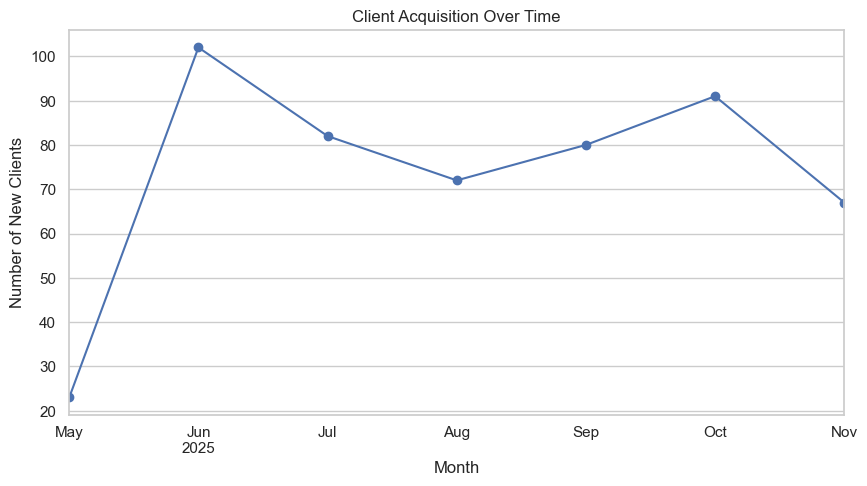

In [170]:
# Client Acquisition over Time
clients_by_month = clients_df.groupby(clients_df["creation_date"].dt.to_period("M")).size()
plt.figure(figsize=(10, 5))
clients_by_month.plot(kind='line', marker='o')
plt.title("Client Acquisition Over Time")
plt.xlabel("Month")
plt.ylabel("Number of New Clients")
plt.grid(True)
plt.show()

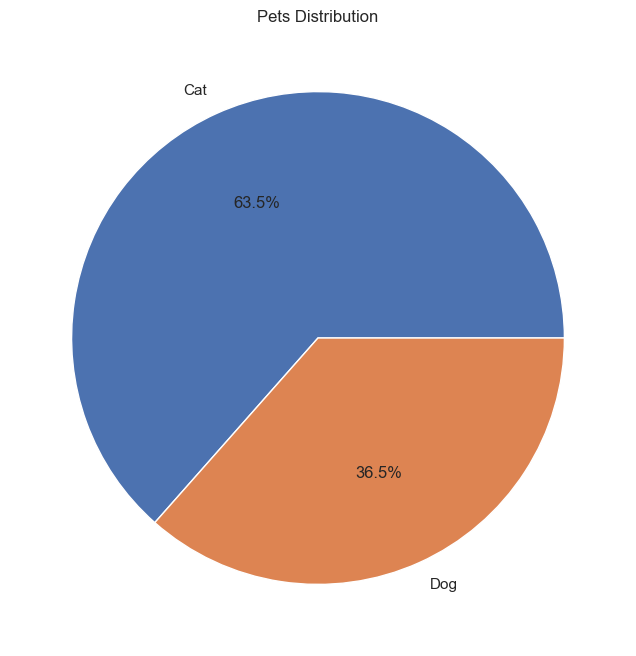

In [171]:
# Pets Distribution
plt.figure(figsize=(8, 8))
pets_df.groupby("type").size().plot(kind="pie", autopct="%1.1f%%" )
plt.title("Pets Distribution")
plt.show()


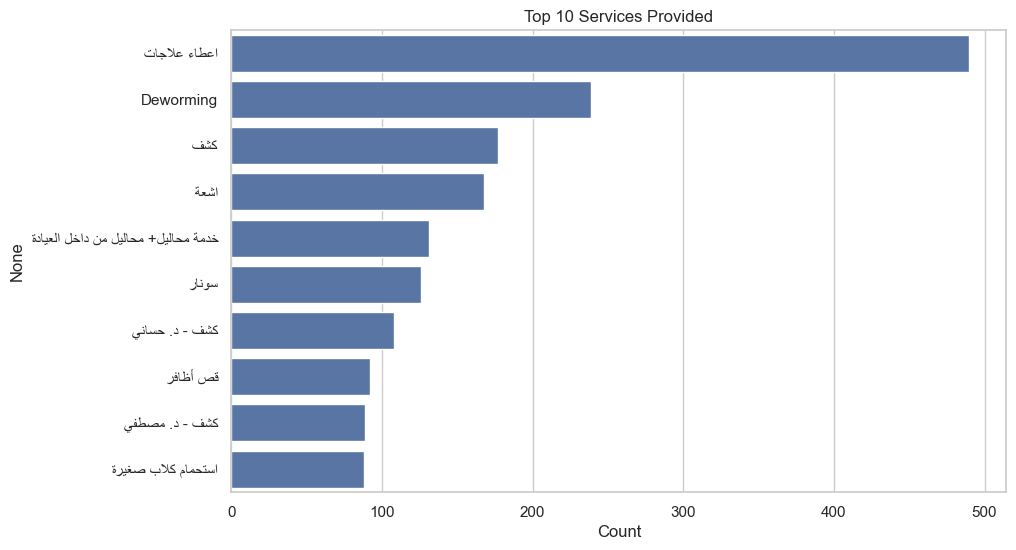

In [172]:
def fix_arabic_text(text):
    if not isinstance(text, str):
        return str(text)
    return get_display(arabic_reshaper.reshape(text))

top_services = services_df['service'].value_counts().head(10)
# Fix Arabic text in index
top_services.index = [fix_arabic_text(label) for label in top_services.index]

plt.figure(figsize=(10, 6))

sns.barplot(x=top_services.values, y=top_services.index)
plt.title("Top 10 Services Provided")
plt.xlabel("Count")
plt.show()

### 4.2 Financial Efficiency

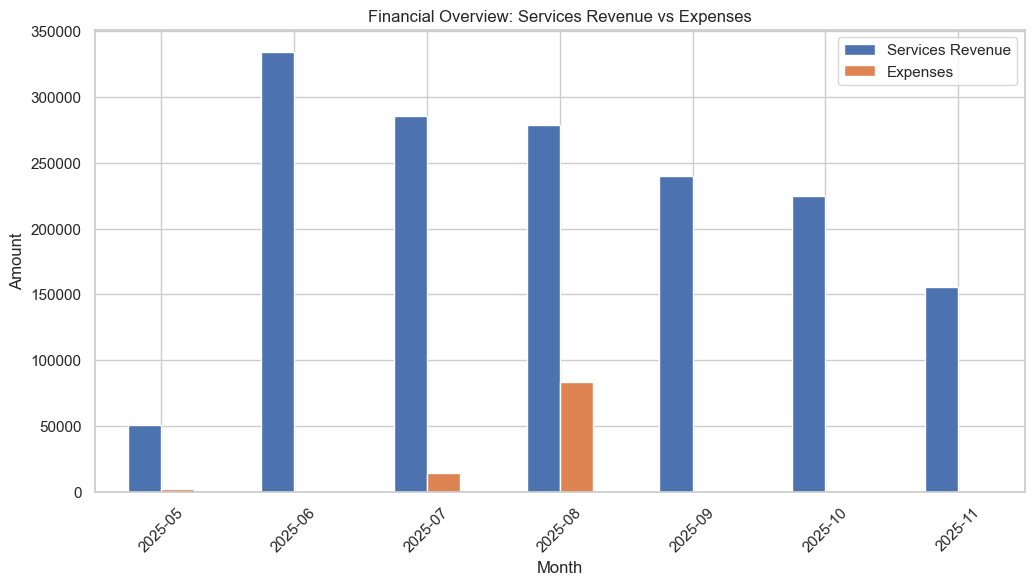

In [173]:
# Calculate Total Revenue and Expenses by Month
# Revenue comes from Services and Inventory Sales

# Prepare Revenue Data
services_revenue = services_df.copy()
services_revenue['revenue'] = services_revenue['sale_price'] * services_revenue['quantity']
services_revenue = services_revenue.groupby(services_revenue['creation_date'].dt.to_period("M"))['revenue'].sum()

# Assuming inventory items sold also count as revenue (need to check if inventory_df represents sales or stock)
# The prompt mentions "Revenues.xlsx" in the file list but I don't see it used in the original code.
# However, 'item.xlsx' has 'sale_price', suggesting sales.
# Let's assume 'item.xlsx' logs items sold.
inventory_revenue = inventory_df.copy()
# inventory_df has 'creation_date' as integer in original code output (1, 2, 3...)?
# Let's check the original output. Ah, in the original output for item.xlsx, creation_date was 1, 2, 3, 4, 5.
# This suggests it might not be a real date in that file, or it needs parsing.
# Wait, the original code did: inventory_df.columns=["creation_date",...]
# But the output showed 1, 2, 3, 4, 5. 
# If 'creation_date' in item.xlsx is not a datetime, we can't group by month easily.
# Let's look at 'service.xlsx', it had real dates.
# Let's look at 'expences.xlsx', it had real dates.

# For now, let's plot Expenses over time, and Services Revenue over time.

expenses_monthly = expenses_df.groupby(expenses_df['creation_date'].dt.to_period("M"))['amount'].sum()

financial_df = pd.DataFrame({
    'Services Revenue': services_revenue,
    'Expenses': expenses_monthly
})

financial_df.plot(kind='bar', figsize=(12, 6))
plt.title("Financial Overview: Services Revenue vs Expenses")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.show()

<Axes: title={'center': 'Top 10 Expenses'}, xlabel='category'>

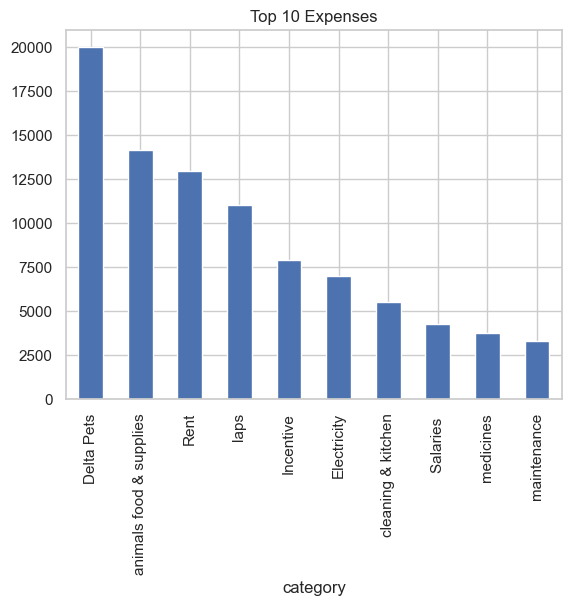

In [174]:

expenses_df.groupby("category")["amount"].sum().sort_values(ascending=False).iloc[:10].plot(kind="bar", title="Top 10 Expenses")

In [175]:
inventory_df.head()

,creation_date,category,item,quantity,cost,sale_price
0,1,Vaccines,drontal cats - ديدان,1.0,103.0,250.0
1,2,N/A,Fipix Cat,1.0,120.0,200.0
2,3,Vaccines,drontal cats - ديدان,1.0,103.0,250.0
3,4,Vaccines,caninua,1.0,155.0,350.0
4,5,N/A,revelution dogs,1.0,400.0,750.0


In [180]:
display(pets_df.info())
display(clients_df.info())

clients_total=pd.merge(clients_df, revenue_df, left_on="phone", right_on="client_phone")
clients_total.index



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   pet_name       638 non-null    object        
 1   code           638 non-null    int64         
 2   creation_date  638 non-null    datetime64[ns]
 3   status         638 non-null    object        
 4   type           638 non-null    object        
 5   client_phone   638 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 30.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           517 non-null    object        
 1   id             517 non-null    int64         
 2   phone          517 non-null    object        
 3   creation_date  517 non-null    datetime64[ns]
 4   status         517 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 20.3+ KB


None

RangeIndex(start=0, stop=1217, step=1)